Notebook used for testing. Later in the main program I may have added improvements such as image orientation correction if required, etc.

# Import stuff

In [3]:
from io import BytesIO

import fitz
import numpy as np
import cv2
from cv2.typing import MatLike


# Read PDF and get image as open-cv matlike
Enter the PDF filepath in the code block below.

In [4]:
def get_table_image_from_pdfbytesio(pdf_bytesio: BytesIO) -> tuple[bytes,str]:
    """Gets image of the table from the PDF.
    Image is expected to be in page 1 of 1 page PDFs and page 2 of other PDFs.

    Args:
        pdf_bytesio (io.BytesIO): PDF as BytesIO

    Raises:
        TableImageException: If found no or more than one image in the target page.

    Returns:
        tuple[bytes,str]: tuple of bytes representing the image, and its extension without the dot(eg: jpeg, not .jpeg)
    """

    fitz_file = fitz.open("pdf", pdf_bytesio)

    if fitz_file.page_count >= 2:
        interested_page_index = 1
    elif fitz_file.page_count == 1:
        interested_page_index = 0
    else:
        raise Exception('PDF file has no pages!')
    page = fitz_file.load_page(interested_page_index) 
    image_list = page.get_images(full=True) 
    if len(image_list) == 0: raise Exception('Found no image in PDF target page.')

    largest_image_size = 0
    for image in image_list:

        image_ref = image[0] # XREF
        base_image = fitz_file.extract_image(image_ref)
        image_size = base_image["height"] * base_image["width"]
        if image_size > largest_image_size:
            largest_image_size = image_size
            image_bytes: bytes = base_image["image"]
            image_ext = base_image["ext"]

    return (image_bytes,image_ext)

# ENTER PDF FILEPATH HERE
PDF_FILEPATH = 'er20241125.pdf' 

with open(PDF_FILEPATH,'rb') as file:
    pdf_bytesio = BytesIO(file.read())

image_bytes,image_extension = get_table_image_from_pdfbytesio(pdf_bytesio)

def convert_bytes_to_openCV_matlike(bytes: bytes) -> MatLike:
    """Converts the bytes of an image read from somwhere (like a stream or the file system)
    into a matlike object that OpenCV likes.

    Args:
        bytes (bytes): bytes of an image that is read from the file system or similar

    Returns:
        matlike: matlike image
    """
    numpy_array = np.fromstring(bytes, np.uint8)
    img = cv2.imdecode(numpy_array, cv2.IMREAD_COLOR)
    return img

base_image = convert_bytes_to_openCV_matlike(image_bytes)

# save base_image to disk
cv2.imwrite(f'base_image.{image_extension}', base_image)

base_image_height,base_image_width,base_image_channels = base_image.shape
base_image_area = base_image_height * base_image_width

/var/folders/d9/wgv0jbcj2f30y4hgl026n2fm0000gn/T/ipykernel_14031/1417126404.py:58: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  numpy_array = np.fromstring(bytes, np.uint8)


# Process Stage 1 - Unwarp the image
Currently the table is somewhere random in the middle of the image. It maybe skewed due to scanner/photograph angle. We need to use perspective transform to unwarp the angle and get just the table.

### grayscalarize -> bilateral filterize -> canny edge detection
skipped grayscale for now cuz I cbb to write the code to display the cell detection and other line detections in color on a grayscale image

In [5]:
# Convert it to grayscale (it's anyway grayscale, but just in case)
# gray = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
gray = base_image.copy()

# Apply bilateral filter. It keeps edges sharp while removing noise. Example: https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
bfilter = cv2.bilateralFilter(gray, 13, 20, 20)

# Apply canny edge detection
edged = cv2.Canny(bfilter, 30, 180)

### Get ALL contours

In [6]:
all_contours,hierachy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

image_with_all_contours = base_image.copy()
cv2.drawContours(image_with_all_contours, all_contours, -1, (0,0,255), 3)

cv2.imwrite(f'image_with_all_contours.{image_extension}', image_with_all_contours)

True

In [7]:
len(all_contours)

5047

In [8]:
all_contours[100].shape

(701, 1, 2)

### Filter the contours that are just words and letters (and not cells).
Hopefully at least just the larger ones.

In [9]:
all_contours_sorted = sorted(all_contours, key=cv2.contourArea, reverse=True)
larger_contours = []

for contour in all_contours_sorted:
    x,y,w,h = cv2.boundingRect(contour)
    area_of_boundingRect = w*h
    if area_of_boundingRect/base_image_area < 0.00086: break
    larger_contours.append(contour)

image_with_larger_contours = base_image.copy()
cv2.drawContours(image_with_larger_contours, larger_contours, -1, (0,0,255), 3)

cv2.imwrite(f'image_with_larger_contours.{image_extension}', image_with_larger_contours)

True

### Contour detection on the mask
to identify the table's 4 corners

In [10]:
# blank image
larger_contours_image = np.zeros((base_image_height,base_image_width,3), np.uint8)
larger_contours_image = cv2.cvtColor(larger_contours_image,cv2.COLOR_BGR2GRAY)
image_with_column_lines_hough = base_image.copy()

cv2.drawContours(larger_contours_image, larger_contours, -1, (255), 3)
cv2.imwrite(f'larger-contours-mask.{image_extension}',larger_contours_image)

True

In [11]:
ext_contours,hierachy = cv2.findContours(larger_contours_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

retr_external_first_only = base_image.copy()
cv2.drawContours(retr_external_first_only, [ext_contours[0]], -1, (255), 3)
cv2.imwrite(f'retr_external_first_only.{image_extension}',retr_external_first_only)

retr_external = base_image.copy()
cv2.drawContours(retr_external, ext_contours, -1, (255), 3)
cv2.imwrite(f'retr_external.{image_extension}',retr_external)

True

In [12]:
# find the 4 corners
import math
def distance_between_2coords(a,b) -> float:
    a0 = a[0]; a1 = a[1]; b0 = b[0]; b1 = b[1]
    term1 = (b0 - a0)*(b0 - a0)
    term2 = (b1 - a1)*(b1 - a1)
    return math.sqrt(term1 + term2)

top_left_min_dist = 1000000; top_right_min_dist = 1000000; bottom_left_min_dist = 1000000; bototom_right_min_dist = 1000000

for contour in ext_contours:
    for point in contour:
        x = point[0][0]
        y = point[0][1]
        dist = distance_between_2coords((x,y),(0,0))
        if dist < top_left_min_dist: 
            top_left = (x,y)
            top_left_min_dist = dist
        dist = distance_between_2coords((x,y),(base_image_width,0))
        if dist < top_right_min_dist: 
            top_right = (x,y)
            top_right_min_dist = dist
        dist = distance_between_2coords((x,y),(base_image_width,base_image_height))
        if dist < bototom_right_min_dist:  
            bottom_right = (x,y)
            bototom_right_min_dist = dist
        dist = distance_between_2coords((x,y),(0,base_image_height))
        if dist < bottom_left_min_dist:  
            bottom_left = (x,y)
            bottom_left_min_dist = dist

table_corner_image = base_image.copy()
cv2.circle(table_corner_image,top_left,5,(0,0,255),-1)
cv2.circle(table_corner_image,top_right,5,(0,0,255),-1)
cv2.circle(table_corner_image,bottom_right,5,(0,0,255),-1)
cv2.circle(table_corner_image,bottom_left,5,(0,0,255),-1)

cv2.imwrite(f'table_corner_image.{image_extension}', table_corner_image)

True

### Unwarp image using the identified table corners

In [13]:
pts1 = np.float32([top_left,top_right,bottom_left,bottom_right])
pts2 = np.float32([[0,0],[base_image_width,0],[0,base_image_height],[base_image_width,base_image_height]])
 
M = cv2.getPerspectiveTransform(pts1,pts2)
 
# can apply unwarping to the bilateral filtered base_image
unwarped_base_image = cv2.warpPerspective(bfilter,M,(base_image_width,base_image_height))

cv2.imwrite(f'unwarped_base_image.{image_extension}', unwarped_base_image)

True

# Process Stage 2 - Determine column and row gridlines

### Get all contours of the unwarped image

In [14]:
edged = cv2.Canny(unwarped_base_image, 30, 180)
all_contours,hierachy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

unwarped_image_with_all_contours = unwarped_base_image.copy()
cv2.drawContours(unwarped_image_with_all_contours, all_contours, -1, (0,0,255), 3)

cv2.imwrite(f'unwarped_image_with_all_contours.{image_extension}', unwarped_image_with_all_contours)

True

### Get larger contours of the unwarped image

In [15]:
all_contours_sorted = sorted(all_contours, key=cv2.contourArea, reverse=True)
larger_contours = []

for contour in all_contours_sorted:
    x,y,w,h = cv2.boundingRect(contour)
    area_of_boundingRect = w*h
    if area_of_boundingRect/base_image_area < 0.00086: break
    larger_contours.append(contour)

unwarped_image_with_larger_contours = unwarped_base_image.copy()
cv2.drawContours(unwarped_image_with_larger_contours, larger_contours, -1, (0,0,255), 3)

unwarped_base_image_larger_contours = larger_contours 

cv2.imwrite(f'unwarped_image_with_larger_contours.{image_extension}', unwarped_image_with_larger_contours)

True

#### Get unwarped image dimensions

In [16]:
unwarped_base_image_height,unwarped_base_image_width,unwarped_base_image_channels = unwarped_base_image.shape
unwarped_base_image_area = unwarped_base_image_height * unwarped_base_image_width
print(unwarped_base_image_height)
print(unwarped_base_image_width)

2936
2104


### Plot the larger contours

2101
2934


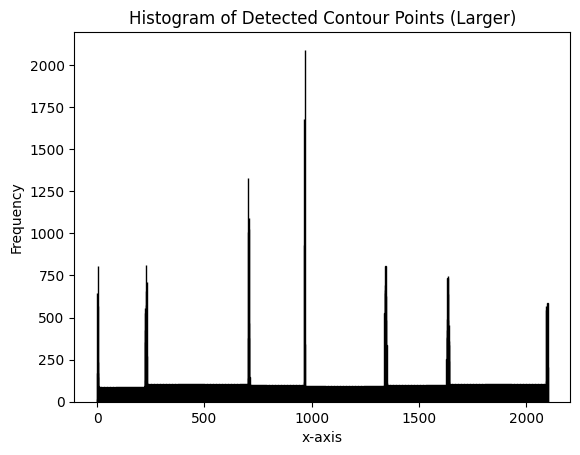

In [17]:
points = set()
max_x = 0; max_y = 0
x_frequencies_dict = {}; y_frequencies_dict = {}

for contour in larger_contours:
    for point in contour:
        x = point[0][0]
        y = point[0][1]
        if (x,y) in points: continue
        points.add((x,y))
        if x not in x_frequencies_dict.keys(): x_frequencies_dict[x] = 1
        else: x_frequencies_dict[x] += 1
        if y not in y_frequencies_dict.keys(): y_frequencies_dict[y] = 1
        else: y_frequencies_dict[y] += 1
        max_x = max(max_x,x)
        max_y = max(max_y,y)

print(max_x)
print(max_y)

x_frequencies = []; y_frequencies = []
for i in range(0,max_x+1): x_frequencies.append(0)
for i in range(0,max_y+1): y_frequencies.append(0)

for value in x_frequencies_dict.keys(): x_frequencies[value] = x_frequencies_dict[value]
for value in y_frequencies_dict.keys(): y_frequencies[value] = y_frequencies_dict[value]

import matplotlib.pyplot as plt

x_axis = list(range(max_x+1))

# Plot frequency chart
plt.bar(x_axis, x_frequencies, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('x-axis')
plt.ylabel('Frequency')
plt.title('Histogram of Detected Contour Points (Larger)')
# plt.xticks(x_axis)

# Show the plot
plt.show()

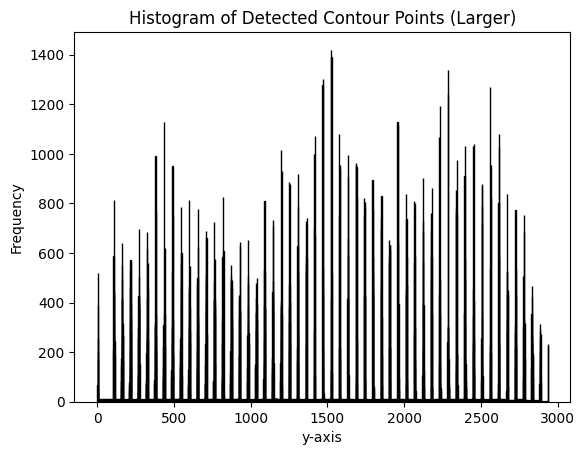

In [18]:
y_axis = list(range(max_y+1))

# Plot frequency chart
plt.bar(y_axis, y_frequencies, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('y-axis')
plt.ylabel('Frequency')
plt.title('Histogram of Detected Contour Points (Larger)')
# plt.xticks(x_axis)

# Show the plot
plt.show()

In [19]:
for i,v in enumerate(y_frequencies):
    print(f'{i}: {v}')

0: 0
1: 0
2: 0
3: 68
4: 518
5: 390
6: 170
7: 258
8: 202
9: 41
10: 10
11: 10
12: 10
13: 10
14: 10
15: 10
16: 10
17: 10
18: 10
19: 10
20: 10
21: 10
22: 10
23: 10
24: 10
25: 10
26: 10
27: 10
28: 10
29: 10
30: 10
31: 10
32: 10
33: 10
34: 10
35: 10
36: 10
37: 10
38: 10
39: 10
40: 10
41: 10
42: 10
43: 10
44: 10
45: 10
46: 10
47: 10
48: 10
49: 10
50: 10
51: 10
52: 10
53: 10
54: 10
55: 10
56: 10
57: 10
58: 10
59: 10
60: 10
61: 10
62: 10
63: 10
64: 10
65: 10
66: 10
67: 10
68: 10
69: 10
70: 10
71: 10
72: 10
73: 10
74: 10
75: 10
76: 10
77: 10
78: 10
79: 10
80: 10
81: 10
82: 10
83: 10
84: 10
85: 10
86: 10
87: 10
88: 10
89: 10
90: 10
91: 10
92: 10
93: 10
94: 10
95: 10
96: 10
97: 10
98: 10
99: 10
100: 10
101: 10
102: 10
103: 10
104: 11
105: 12
106: 209
107: 587
108: 447
109: 314
110: 436
111: 813
112: 254
113: 246
114: 244
115: 190
116: 13
117: 12
118: 12
119: 12
120: 12
121: 12
122: 12
123: 12
124: 12
125: 12
126: 12
127: 12
128: 12
129: 12
130: 12
131: 12
132: 12
133: 12
134: 12
135: 12
136: 12
13

### Use scipy to find peaks (vertical lines)

- https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy/
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [20]:
import scipy.signal as sp_sig

peaks, properties = sp_sig.find_peaks(x_frequencies, prominence=1, distance=int(unwarped_base_image_height*(50/3000)), width=1)
# print(peaks)
# print(properties)

peaks_with_properties = []

for i in range(0,len(peaks)):
    peak = peaks[i]
    dictionary = {}
    dictionary['prominence'] = properties['prominences'][i]
    dictionary['widths'] = properties['widths'][i]
    dictionary['left_ips'] = properties['left_ips'][i]
    dictionary['right_ips'] = properties['right_ips'][i]
    peaks_with_properties.append((peak,dictionary))

peaks_with_properties.sort(key=lambda x: x[1]['prominence'], reverse=True)
max_prominence_column = peaks_with_properties[0][1]['prominence']
print(max_prominence_column)
# print(peaks_with_properties[:7])
for i in range(0,7):
    peak_with_property = peaks_with_properties[i]
    print(f"peak - {peak_with_property[0]}")
    print(f"prominence - {peak_with_property[1]['prominence']}")
    print(f"widths - {peak_with_property[1]['widths']}")
    print(f"left_ips - {peak_with_property[1]['left_ips']}")
    print(f"right_ips - {peak_with_property[1]['right_ips']}")
    print()

# image_with_columns_identified_pure_vertical = unwarped_base_image.copy()
# for peak in peaks_with_properties[:7]:
#     x = peak[0]
#     cv2.line(image_with_columns_identified_pure_vertical, (x,0), (x,base_image_height), (0,0,255), 3)
# cv2.imwrite(f'image_with_columns_pure_vertical.{image_extension}', image_with_columns_identified_pure_vertical)

vertical_lines = []

for peak in peaks_with_properties:
    prominence = peak[1]['prominence']
    if prominence < max_prominence_column*0.25: break
    left_ips = peak[1]['left_ips']
    right_ips = peak[1]['right_ips']
    vertical_lines.append(((round(left_ips),0),(round(right_ips),base_image_height)))


1997.0
peak - 969
prominence - 1997.0
widths - 1.0613393639241622
left_ips - 968.5105392156863
right_ips - 969.5718785796105

peak - 705
prominence - 1312.0
widths - 2.0714544226808584
left_ips - 703.6168981481482
right_ips - 705.688352570829

peak - 3
prominence - 721.0
widths - 1.9234636208206686
left_ips - 2.43671875
right_ips - 4.360182370820668

peak - 227
prominence - 707.0
widths - 5.989975254111016
left_ips - 225.59011627906978
right_ips - 231.5800915331808

peak - 1345
prominence - 707.0
widths - 3.8476648899525117
left_ips - 1343.3391167192428
right_ips - 1347.1867816091954

peak - 1635
prominence - 644.0
widths - 4.591904761904743
left_ips - 1633.1114285714286
right_ips - 1637.7033333333334

peak - 2100
prominence - 378.0
widths - 1.2559999999998581
left_ips - 2099.244
right_ips - 2100.5



### Add for horizontal peaks

In [21]:
peaks, properties = sp_sig.find_peaks(y_frequencies, prominence=1, distance=int(unwarped_base_image_width*(30/2000)), width=1)
# print(peaks)
# print(properties)

peaks_with_properties = []
print(f'len peaks = {len(peaks)}')

for i in range(0,len(peaks)):
    peak = peaks[i]
    dictionary = {}
    dictionary['prominence'] = properties['prominences'][i]
    dictionary['widths'] = properties['widths'][i]
    dictionary['left_ips'] = properties['left_ips'][i]
    dictionary['right_ips'] = properties['right_ips'][i]
    peaks_with_properties.append((peak,dictionary))

peaks_with_properties.sort(key=lambda x: x[1]['prominence'], reverse=True)
max_prominence_column = peaks_with_properties[0][1]['prominence']
print(max_prominence_column)
# print(peaks_with_properties[:7])
for i in range(0,len(peaks)):
    peak_with_property = peaks_with_properties[i]
    print(f"peak - {peak_with_property[0]}")
    print(f"prominence - {peak_with_property[1]['prominence']}")
    print(f"widths - {peak_with_property[1]['widths']}")
    print(f"left_ips - {peak_with_property[1]['left_ips']}")
    print(f"right_ips - {peak_with_property[1]['right_ips']}")
    print()

horizontal_lines = []

for peak in peaks_with_properties:
    prominence = peak[1]['prominence']
    if prominence < max_prominence_column*0.25: break
    left_ips_h = peak[1]['left_ips']
    right_ips_h = peak[1]['right_ips']
    horizontal_lines.append(((0,round(left_ips_h)),(unwarped_base_image_width,round(right_ips_h))))


len peaks = 53
1418.0
peak - 1522
prominence - 1418.0
widths - 1.2566411373140909
left_ips - 1521.4495341614906
right_ips - 1522.7061752988047

peak - 2286
prominence - 1330.0
widths - 1.2800876692431302
left_ips - 2285.361804222649
right_ips - 2286.641891891892

peak - 1472
prominence - 1291.0
widths - 1.4392783450482511
left_ips - 1471.4056169429098
right_ips - 1472.844895287958

peak - 2559
prominence - 1258.0
widths - 1.4041242705015975
left_ips - 2558.1418826739427
right_ips - 2559.5460069444443

peak - 2232
prominence - 1181.0
widths - 1.5396161002609006
left_ips - 2231.160028449502
right_ips - 2232.699644549763

peak - 436
prominence - 1120.0
widths - 1.3356845722553885
left_ips - 435.2783505154639
right_ips - 436.6140350877193

peak - 1956
prominence - 1117.0
widths - 1.119599069267906
left_ips - 1955.496846846847
right_ips - 1956.6164459161148

peak - 2617
prominence - 1070.0
widths - 1.7110833339802412
left_ips - 2616.372801875733
right_ips - 2618.083885209713

peak - 1576
pr

### Final image with grid

In [22]:
horizontal_lines.sort(key=lambda x: x[0][1])
horizontal_lines

[((0, 3), (2104, 6)),
 ((0, 110), (2104, 112)),
 ((0, 160), (2104, 166)),
 ((0, 214), (2104, 220)),
 ((0, 269), (2104, 276)),
 ((0, 325), (2104, 328)),
 ((0, 380), (2104, 382)),
 ((0, 435), (2104, 437)),
 ((0, 490), (2104, 492)),
 ((0, 544), (2104, 547)),
 ((0, 599), (2104, 601)),
 ((0, 653), (2104, 656)),
 ((0, 706), (2104, 711)),
 ((0, 761), (2104, 766)),
 ((0, 818), (2104, 820)),
 ((0, 870), (2104, 878)),
 ((0, 925), (2104, 930)),
 ((0, 979), (2104, 983)),
 ((0, 1033), (2104, 1041)),
 ((0, 1088), (2104, 1091)),
 ((0, 1142), (2104, 1145)),
 ((0, 1197), (2104, 1199)),
 ((0, 1251), (2104, 1253)),
 ((0, 1309), (2104, 1311)),
 ((0, 1363), (2104, 1366)),
 ((0, 1417), (2104, 1419)),
 ((0, 1471), (2104, 1473)),
 ((0, 1521), (2104, 1523)),
 ((0, 1575), (2104, 1577)),
 ((0, 1630), (2104, 1632)),
 ((0, 1684), (2104, 1687)),
 ((0, 1738), (2104, 1741)),
 ((0, 1792), (2104, 1795)),
 ((0, 1851), (2104, 1853)),
 ((0, 1901), (2104, 1904)),
 ((0, 1955), (2104, 1957)),
 ((0, 2009), (2104, 2012)),
 ((0

In [23]:
vertical_lines.sort(key=lambda x: x[0][0])
vertical_lines

[((2, 0), (4, 2936)),
 ((226, 0), (232, 2936)),
 ((704, 0), (706, 2936)),
 ((969, 0), (970, 2936)),
 ((1343, 0), (1347, 2936)),
 ((1633, 0), (1638, 2936))]

### if there is no line within 10 px from the table edges, create a line on the edge

In [24]:
if horizontal_lines[0][0][1] > 20: horizontal_lines.insert(0,((0, 0), (unwarped_base_image_width, 0)))
if unwarped_base_image_height - horizontal_lines[-1][0][1] > 20: horizontal_lines.append(((0, unwarped_base_image_height), (unwarped_base_image_width, unwarped_base_image_height)))

if vertical_lines[0][0][0] > 20: vertical_lines.insert(0,((0, 0), (0, unwarped_base_image_height)))
if unwarped_base_image_width - vertical_lines[-1][0][0] > 20: vertical_lines.append(((unwarped_base_image_width, 0), (unwarped_base_image_width, unwarped_base_image_height)))

vertical_lines

[((2, 0), (4, 2936)),
 ((226, 0), (232, 2936)),
 ((704, 0), (706, 2936)),
 ((969, 0), (970, 2936)),
 ((1343, 0), (1347, 2936)),
 ((1633, 0), (1638, 2936)),
 ((2104, 0), (2104, 2936))]

In [25]:
horizontal_lines

[((0, 3), (2104, 6)),
 ((0, 110), (2104, 112)),
 ((0, 160), (2104, 166)),
 ((0, 214), (2104, 220)),
 ((0, 269), (2104, 276)),
 ((0, 325), (2104, 328)),
 ((0, 380), (2104, 382)),
 ((0, 435), (2104, 437)),
 ((0, 490), (2104, 492)),
 ((0, 544), (2104, 547)),
 ((0, 599), (2104, 601)),
 ((0, 653), (2104, 656)),
 ((0, 706), (2104, 711)),
 ((0, 761), (2104, 766)),
 ((0, 818), (2104, 820)),
 ((0, 870), (2104, 878)),
 ((0, 925), (2104, 930)),
 ((0, 979), (2104, 983)),
 ((0, 1033), (2104, 1041)),
 ((0, 1088), (2104, 1091)),
 ((0, 1142), (2104, 1145)),
 ((0, 1197), (2104, 1199)),
 ((0, 1251), (2104, 1253)),
 ((0, 1309), (2104, 1311)),
 ((0, 1363), (2104, 1366)),
 ((0, 1417), (2104, 1419)),
 ((0, 1471), (2104, 1473)),
 ((0, 1521), (2104, 1523)),
 ((0, 1575), (2104, 1577)),
 ((0, 1630), (2104, 1632)),
 ((0, 1684), (2104, 1687)),
 ((0, 1738), (2104, 1741)),
 ((0, 1792), (2104, 1795)),
 ((0, 1851), (2104, 1853)),
 ((0, 1901), (2104, 1904)),
 ((0, 1955), (2104, 1957)),
 ((0, 2009), (2104, 2012)),
 ((0

In [26]:
image_with_final_grid = unwarped_base_image.copy()

for line in horizontal_lines:
    cv2.line(image_with_final_grid, line[0], line[1], (0,0,255), 3)

for line in vertical_lines:
    cv2.line(image_with_final_grid, line[0], line[1], (0,0,255), 3)

cv2.imwrite(f'image_with_final_grid.{image_extension}', image_with_final_grid)

True

# Stage 3 - use the detected gridlines to scissor the table into individual cells (that can later be passed to Tesseract)

In [27]:
def find_intersection_points_per_row(horizontal_lines: list[tuple[tuple[int,int],tuple[int,int]]], 
                                              vertical_lines: list[tuple[tuple[int,int],tuple[int,int]]]):
    intersection_points_per_row = []
    for row in horizontal_lines:
        intersection_points_in_this_row = []
        for col in vertical_lines:
            intersection_point = line_intersection(row,col)
            intersection_points_in_this_row.append(intersection_point)
        intersection_points_per_row.append(intersection_points_in_this_row)

    return intersection_points_per_row

def line_intersection(line1, line2):
    """
    Finds the intersection point of two lines defined by their endpoints.

    Args:
        line1: A tuple of two points (x1, y1) and (x2, y2) defining the first line.
        line2: A tuple of two points (x3, y3) and (x4, y4) defining the second line.

    Returns:
        A tuple (x, y) representing the intersection point, or None if the lines are parallel or coincident.
    """
    (x1, y1), (x2, y2) = line1
    (x3, y3), (x4, y4) = line2

    # Calculate the determinants
    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    if det == 0:
        # Lines are parallel or coincident
        return None

    # Calculate the intersection point
    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det

    return int(px), int(py)



intersection_points_per_row = find_intersection_points_per_row(horizontal_lines,vertical_lines)
print(f'len of intersection_points_per_row {len(intersection_points_per_row)}')

cell_coords = []
i = 0; j = 0
while True:
    intersection_points_in_this_row = intersection_points_per_row[i]
    try: intersection_points_in_next_row = intersection_points_per_row[i+1]
    except IndexError: break
    while True:
        top_left = intersection_points_in_this_row[j]
        bottom_left = intersection_points_in_next_row[j]
        try: top_right = intersection_points_in_this_row[j+1]
        except IndexError: break
        bottom_right = intersection_points_in_next_row[j+1]
        cell_coords.append((top_left,top_right,bottom_right,bottom_left))
        j += 1
    j = 0
    i += 1
# return cell_coords
print(len(cell_coords))
print(cell_coords)


len of intersection_points_per_row 53
312
[((2, 3), (226, 3), (226, 110), (2, 110)), ((226, 3), (704, 4), (704, 110), (226, 110)), ((704, 4), (969, 4), (969, 110), (704, 110)), ((969, 4), (1343, 4), (1343, 111), (969, 110)), ((1343, 4), (1633, 5), (1633, 111), (1343, 111)), ((1633, 5), (2104, 6), (2104, 112), (1633, 111)), ((2, 110), (226, 110), (226, 160), (2, 160)), ((226, 110), (704, 110), (704, 162), (226, 160)), ((704, 110), (969, 110), (969, 162), (704, 162)), ((969, 110), (1343, 111), (1343, 163), (969, 162)), ((1343, 111), (1633, 111), (1633, 164), (1343, 163)), ((1633, 111), (2104, 112), (2104, 166), (1633, 164)), ((2, 160), (226, 160), (226, 214), (2, 214)), ((226, 160), (704, 162), (704, 216), (226, 214)), ((704, 162), (969, 162), (969, 216), (704, 216)), ((969, 162), (1343, 163), (1343, 217), (969, 216)), ((1343, 163), (1633, 164), (1633, 218), (1343, 217)), ((1633, 164), (2104, 166), (2104, 220), (1633, 218)), ((2, 214), (226, 214), (226, 269), (2, 269)), ((226, 214), (704

### Make an image without gridlines (as much as possible) from the unwarped_base_image

In [28]:
unwarped_base_image_larger_contours

gridless_image = unwarped_base_image.copy()

for contour in unwarped_base_image_larger_contours:
    for point in contour:
        x = point[0][0]; y = point[0][1]
        for Y in range(y-3,y+4):
            for X in range(x-3,x+4):
                try: gridless_image[Y,X] = [255,255,255]
                except IndexError: continue

cv2.imwrite('gridless.jpeg',gridless_image)




True

### Start cropping :)

In [29]:
cell_images = []
for coords in cell_coords:
    top_left,top_right,bottom_right,bottom_left = coords
    print(top_left)
    print(top_right)
    print(bottom_right)
    print(bottom_left)
    img = gridless_image.copy()
    cell = img[top_left[1]:bottom_left[1], top_left[0]:top_right[0]]
    cell_images.append(cell)
    # cv2.imshow('cell',cell)
    # cv2.waitKey(0)

import os
os.makedirs('cells', exist_ok=True)
for i,cell_image in enumerate(cell_images):
    cv2.imwrite(f'cells/{i}.jpeg',cell_image)

(2, 3)
(226, 3)
(226, 110)
(2, 110)
(226, 3)
(704, 4)
(704, 110)
(226, 110)
(704, 4)
(969, 4)
(969, 110)
(704, 110)
(969, 4)
(1343, 4)
(1343, 111)
(969, 110)
(1343, 4)
(1633, 5)
(1633, 111)
(1343, 111)
(1633, 5)
(2104, 6)
(2104, 112)
(1633, 111)
(2, 110)
(226, 110)
(226, 160)
(2, 160)
(226, 110)
(704, 110)
(704, 162)
(226, 160)
(704, 110)
(969, 110)
(969, 162)
(704, 162)
(969, 110)
(1343, 111)
(1343, 163)
(969, 162)
(1343, 111)
(1633, 111)
(1633, 164)
(1343, 163)
(1633, 111)
(2104, 112)
(2104, 166)
(1633, 164)
(2, 160)
(226, 160)
(226, 214)
(2, 214)
(226, 160)
(704, 162)
(704, 216)
(226, 214)
(704, 162)
(969, 162)
(969, 216)
(704, 216)
(969, 162)
(1343, 163)
(1343, 217)
(969, 216)
(1343, 163)
(1633, 164)
(1633, 218)
(1343, 217)
(1633, 164)
(2104, 166)
(2104, 220)
(1633, 218)
(2, 214)
(226, 214)
(226, 269)
(2, 269)
(226, 214)
(704, 216)
(704, 271)
(226, 269)
(704, 216)
(969, 216)
(969, 272)
(704, 271)
(969, 216)
(1343, 217)
(1343, 273)
(969, 272)
(1343, 217)
(1633, 218)
(1633, 274)
(134

# Stage 4 - Convert cell images to csv string

In [30]:
import subprocess
import re

def get_ocr_of_image(image: MatLike, psm: str = '3') -> str:
    """Takes image (in the format of opencv matlike) and returns string of recognized text

    Args:
        image (matlike): Image (in the format of opencv matlike)
        psm (str, optional): _description_. Defaults to '3' as this is the tesseract default psm.

    Returns:
        str: Recongnized text
    """
    image_bytes_io = __convert_matlike_to_bytesIO(image)
    image_bytes = image_bytes_io.read()
    # result = subprocess.run(['tesseract', 'stdin', 'stdout'], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    process = subprocess.Popen(['tesseract', 'stdin', 'stdout', '--psm', psm], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    result = process.communicate(input=image_bytes)
    stdout = result[0]
    output = stdout.decode()
    return output


def __convert_matlike_to_bytesIO(image: MatLike) -> BytesIO:
    """Converts a matlike image (typically from OpenCV) to BytesIO for a png image

    Args:
        image (matlike): matlike image (typically from OpenCV)

    Returns:
        BytesIO: BytesIO representation of a png image
    """
    _,encoded_image = cv2.imencode('.png', image)
    image_bytes_io = BytesIO(encoded_image.tobytes())
    # with open('test.png', 'wb') as file:
    #     file.write(image_bytes.getvalue())
    return image_bytes_io

def remove_cell_border(cell): return cell


def cell_images_to_csvstring(cell_images: list[MatLike]) -> str:
    """Performs the OCR process on the list of cell images, and collects the detected text into a csv string.

    Args:
        cell_images (list[MatLike]): list of cell images (in order of the table)

    Returns:
        str: csv string of the table represented by the list of cell images
    """

    # separate the cell images by column heading
    country = []
    country_code = []
    currency = []
    currency_code = []
    er = []

    col_counter = -1
    for cell_image in cell_images:
        col_counter += 1
        if col_counter == 0: 
            continue
        if col_counter == 1:
            country.append(cell_image)
        if col_counter == 2:
            country_code.append(cell_image)
        if col_counter == 3:
            currency.append(cell_image)
        if col_counter == 4:
            currency_code.append(cell_image)
        if col_counter == 5:
            er.append(cell_image)
            col_counter = -1

    # lists for holding the ocr results
    country_ocr = []
    country_code_ocr = []
    currency_ocr = []
    currency_code_ocr = []
    er_ocr = []

    # for each type of cell (belonging to a certain column), apply OCR and column-specific regex
    for cell in country:
        cropped_cell = remove_cell_border(cell)
        string = get_ocr_of_image(cropped_cell, '7')
        string = string.strip()
        string = re.sub('^[^a-zA-Z0-9.()]+|[^a-zA-Z0-9.()]+$', '', string) # OCR is likely to falsely detect special characters at the start and end of text
        string = string.strip()
        string = string.replace(',','') # commas anywhere in the text must be removed because we are using .csv
        country_ocr.append(string)

    for cell in er:
        cropped_cell = remove_cell_border(cell)
        string = get_ocr_of_image(cropped_cell, '7')
        string = string.strip()
        string = re.sub('^[^0-9]+|[^0-9]+$', '', string) # OCR is likely to falsely detect special characters at the start and end of text
        string = string.replace(' ', '') # exchange rates don't have spaces
        string = string.strip()     
        string = string.replace(',','') # commas anywhere in the text must be removed because we are using .csv
        er_ocr.append(string)

    for cell in currency_code:
        cropped_cell = remove_cell_border(cell)
        string = get_ocr_of_image(cropped_cell, '7')
        string = string.strip()
        string = re.sub('^[^A-Z]+|[^A-Z]+$', '', string) # OCR is likely to falsely detect special characters at the start and end of text
        string = string.strip()
        string = string.replace(',','') # commas anywhere in the text must be removed because we are using .csv
        currency_code_ocr.append(string)

    for cell in country_code:
        cropped_cell = remove_cell_border(cell)
        string = get_ocr_of_image(cropped_cell, '7')
        string = string.strip()
        string = re.sub('^[^A-Z]+|[^A-Z]+$', '', string) # OCR is likely to falsely detect special characters at the start and end of text
        string = string.strip()
        string = string.replace(',','') # commas anywhere in the text must be removed because we are using .csv
        country_code_ocr.append(string)

    for cell in currency:
        cropped_cell = remove_cell_border(cell)
        string = get_ocr_of_image(cropped_cell, '7')
        string = string.strip()
        string = re.sub('^[^a-zA-Z0-9.()]+|[^a-zA-Z0-9.()]+$', '', string) # OCR is likely to falsely detect special characters at the start and end of text
        string = string.strip()
        string = string.replace(',','') # commas anywhere in the text must be removed because we are using .csv
        currency_ocr.append(string)

    # collect all into a csv string
    csv_string = ''
    for i in range(0,len(country_ocr)):
        csv_string += f'{country_ocr[i]},{country_code_ocr[i]},{currency_ocr[i]},{currency_code_ocr[i]},{er_ocr[i]}\n'

    return csv_string


csv_string = cell_images_to_csvstring(cell_images)

with open('output.csv', 'wt') as output:
    output.write(csv_string)

Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!
Image too small to scale!! (2x36 vs min width of 3)
Line cannot be recognized!!
